In [112]:
import keras
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Flatten, MaxPooling2D
from keras.regularizers import l2, activity_l2,l1
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
from scipy import misc
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [127]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

### Generate model with VGG16 feature extractors, set trainable false

In [117]:
def getModel( output_dim ):
    # output_dim: the number of classes (int)
    # return: compiled model (keras.engine.training.Model)
    
    vgg_model = VGG16( weights='imagenet', include_top=True )
    vgg_out = vgg_model.layers[-5].output 
    vgg_out = MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='default')(vgg_out)
    vgg_out = Flatten()(vgg_out)
    vgg_out = Dropout(0.25)(vgg_out)
    softmax = Dense( output_dim, activation="softmax", W_regularizer = l2(0.01))( vgg_out )
    

    tl_model = Model( input=vgg_model.input, output=softmax )
    # Transfer Learning
    for layer in tl_model.layers[0:-1]:
        layer.trainable = False            

    tl_model.compile(loss= "categorical_crossentropy", optimizer="adadelta", metrics=["acc"])
    
    return tl_model

### Loading all images into 'album'

In [93]:
def loadImages(path = '/mnt/cube/UT_/Urban_tribes/'):
    album = {}
    for item in listdir(path):
        category = item[0:4]
        if category == ".ipy":
            continue
        if category not in album:
            album[category] = []
        
        img = load_img(path+item)
        img = img_to_array(img)
        img = misc.imresize(img, (224, 224))
        img = scipy.misc.imrotate(img, 180)
        album[category].append(img)
    return album

In [94]:
album = loadImages()

### Split 'album' into dataset
Album is split into training and testing input/outputs according to number of examples attribute

In [95]:
def make_dataset(album, n_train, n_test):
    trn_inp = []
    trn_out = []
    tst_inp = []
    tst_out = []    
    keys = album.keys()
    for key in keys:
        examples = album[key]
        l = len(examples)
        idx = np.random.choice(l, n_train+n_test)
        for i in idx[:-n_test]:
            trn_inp.append(examples[i])
            trn_out.append(keys.index(key))
        for i in idx[-n_test:]:
            tst_inp.append(examples[i])
            tst_out.append(keys.index(key))
    return [trn_inp, trn_out, tst_inp, tst_out]      

In [97]:
samCat = 70
dataset = make_dataset(album, samCat, 30)

In [99]:
trainX = np.array(dataset[0])
trainY = np.array(dataset[1])

# Now shuffle the training data and swapaxes
idx = np.random.choice(len(trainX), len(trainX))
trainX = trainX[idx]
trainY = trainY[idx]

trainX = preprocess_input(np.float64(trainX)).swapaxes(1, 3).swapaxes(2, 3)
trainY = np_utils.to_categorical(trainY)

# Only swapaxes for testing data
testX = np.array(dataset[2])
testY = np.array(dataset[3])

testX = preprocess_input(np.float64(testX)).swapaxes(1, 3).swapaxes(2, 3)
testY = np_utils.to_categorical(testY)

### Fit the model

In [118]:
model = getModel(11)

In [119]:
history = model.fit(trainX, trainY, batch_size = 16, nb_epoch = 30, validation_data = (testX, testY), shuffle=True)

Train on 770 samples, validate on 330 samples
Epoch 1/30
770/770 [==============================] - 25s - loss: 13.5333 - acc: 0.1156 - val_loss: 12.7761 - val_acc: 0.1424
Epoch 2/30
770/770 [==============================] - 25s - loss: 11.8313 - acc: 0.2091 - val_loss: 12.2107 - val_acc: 0.1758
Epoch 3/30
770/770 [==============================] - 25s - loss: 10.9558 - acc: 0.2623 - val_loss: 12.0840 - val_acc: 0.1939
Epoch 4/30
770/770 [==============================] - 25s - loss: 10.2176 - acc: 0.3000 - val_loss: 10.8501 - val_acc: 0.2576
Epoch 5/30
770/770 [==============================] - 25s - loss: 9.0273 - acc: 0.3623 - val_loss: 10.2509 - val_acc: 0.2848
Epoch 6/30
770/770 [==============================] - 25s - loss: 8.2702 - acc: 0.4013 - val_loss: 9.7809 - val_acc: 0.3030
Epoch 7/30
770/770 [==============================] - 25s - loss: 7.2427 - acc: 0.4974 - val_loss: 9.2681 - val_acc: 0.3333
Epoch 8/30
770/770 [==============================] - 25s - loss: 6.8504 - ac

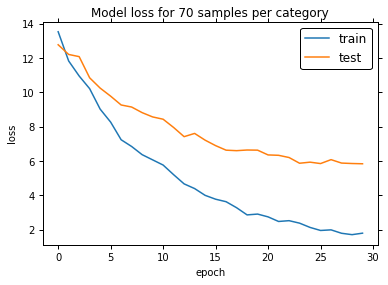

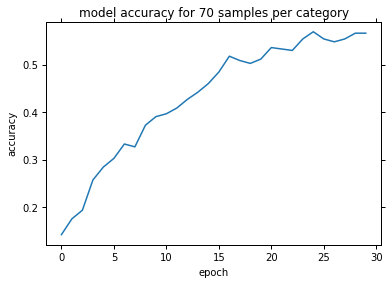

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for %d samples per category' % samCat)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['val_acc'])
plt.title('model accuracy for %d samples per category' % samCat)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

### We are going to visualize the activations from the convolutional layers now.

In [86]:
# Used Keras blog as guide, reference added in the report
from keras import backend as K

kernel_id = 20 

activations = model.layers[1].output
loss = K.mean(activations[:, kernel_id, :, :])
input_img = model.layers[0].output

grads = K.gradients(loss, input_img)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([input_img], [loss, grads])

In [87]:
input_img_data = np.random.random((1, 3, 300, 300)) * 20 + 128.
eta = 1

for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * eta

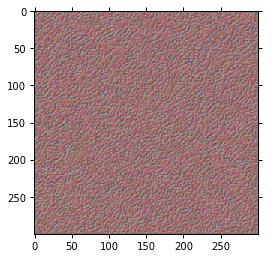

In [91]:
def deprocess(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess(img)
plt.imshow(img, cmap = plt.cm.gray)
plt.show()

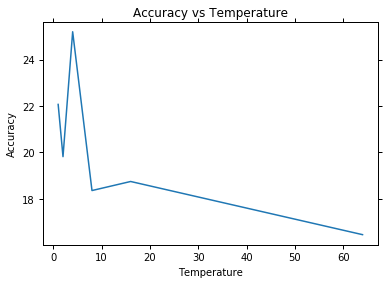

In [126]:
X=[1, 2, 4, 8, 16, 64]
Y=[22.07, 19.82, 25.20, 18.36, 18.75, 16.46]
plt.plot(X, Y)
plt.title('Accuracy vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.show()